In [11]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    auc,
    classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
def carregar_dados_csv(file):

	try:
		
		df_completo = pd.read_csv(file)

		return df_completo

	except FileNotFoundError:

		print(f"Erro: O arquivo '{file}' não foi encontrado.")
		print("Rode o ZeaMays para gerar o arquivo CSV.")
		return None

	except KeyError as e:

		print(f"Erro: Uma ou mais colunas não encontradas no arquivo: {e}")
		return None

	except Exception as e:

		print(f"Ocorreu um erro inesperado: {e}")
		return None

In [ ]:
metricas = "df_metricas_seq.csv"

df_metricas = carregar_dados_csv(metricas)

if df_metricas is not None:
	print("\nHead do DataFrame:")
	print(df_metricas.shape)
	print(df_metricas.head())


Head do DataFrame:
   Chr SourceAnnotation                                    COS      Start  \
0    1           APTEdb  Class II subclass 2/Helitron/Helitron  185134318   
1    1           APTEdb  Class II subclass 2/Helitron/Helitron  108502298   
2    9           APTEdb  Class II subclass 2/Helitron/Helitron   77998293   
3    4           APTEdb  Class II subclass 2/Helitron/Helitron  206727217   
4    8           APTEdb  Class II subclass 2/Helitron/Helitron  165674147   

         End Score Strand Phase  \
0  185151509     .      -     .   
1  108504248     .      -     .   
2   78002783     .      +     .   
3  206731508     .      +     .   
4  165674275     .      -     .   

                                          Attributes  \
0  TE-Score=0.714;Software=HelitronScanner;Length...   
1  TE-Score=0.428;Software=HelitronScanner;Length...   
2  TE-Score=0.714;Software=HelitronScanner;Length...   
3  TE-Score=0.428;Software=HelitronScanner;Length...   
4  TE-Score=0.142;Software

In [ ]:
remover_colunas = ["Chr", "SourceAnnotation", "Start", "End", "Score", "Strand", "Phase", "Attributes", "label"]

df_modificado = df_metricas.drop(columns=remover_colunas)

print("\nDataFrame após remover colunas:")
print(df_modificado.shape)
print(df_modificado.head())


DataFrame após remover colunas:
(67686, 5758)
                                     COS  ZMays/Agrup\anf_fourier_average  \
0  Class II subclass 2/Helitron/Helitron                      1109.133954   
1  Class II subclass 2/Helitron/Helitron                       146.131903   
2  Class II subclass 2/Helitron/Helitron                       306.033744   
3  Class II subclass 2/Helitron/Helitron                       306.207420   
4  Class II subclass 2/Helitron/Helitron                        11.691824   

   ZMays/Agrup\anf_fourier_median  ZMays/Agrup\anf_fourier_maximum  \
0                       10.007322                     1.881748e+07   
1                        6.389373                     2.643780e+05   
2                        6.873558                     1.326329e+06   
3                        8.069504                     1.260339e+06   
4                        0.949723                     1.346578e+03   

   ZMays/Agrup\anf_fourier_minimum  ZMays/Agrup\anf_fourier_peak  \
0

In [ ]:
import pandas as pd
import numpy as np # Necessário para np.nan em alguns casos, e tipos numéricos

def preprocessar_dataframe(df):
	
	if not isinstance(df, pd.DataFrame):
		print("Erro: A entrada deve ser um DataFrame do pandas.")
		return None

	df_processado = df.copy()
	print("--- Iniciando Pré-processamento ---")
	print(f"Dimensões originais: {df_processado.shape}")

	# Remover linhas duplicadas
	duplicatas_antes = df_processado.duplicated().sum()
	if duplicatas_antes > 0:
		df_processado.drop_duplicates(keep='first', inplace=True) # Manter a primeira ocorrência
		print(f"   Removidas {duplicatas_antes} linhas duplicadas.")
		print(f"   Dimensões atuais: {df_processado.shape}")
	else:
		print("1. Nenhuma linha duplicada encontrada.")

	# Remover linhas onde há valores nulos
	linhas_nulas_total_antes = df_processado.isnull().any(axis=1).sum()
	
	if linhas_nulas_total_antes > 0:

		df_processado.dropna(how='any', inplace=True)
		print(f"2. Removidas {linhas_nulas_total_antes} linhas onde havia valores nulos.")
		print(f"   Dimensões atuais: {df_processado.shape}")
		
	else:
		print("2. Nenhuma linha com valores nulos encontrada.")

	# Resetar o índice
	df_processado.reset_index(drop=True, inplace=True)
	print("\n--- Pré-processamento Concluído ---")
	print(f"Dimensões finais do DataFrame processado: {df_processado.shape}")

	return df_processado

In [ ]:
df = preprocessar_dataframe(df_modificado)

if df is not None:
	print("\n")
	print(df.head())
	# print("\nInformações do DataFrame:")
	# pos_df.info()

--- Iniciando Pré-processamento ---
Dimensões originais: (5, 5)
1. Nenhuma linha duplicada encontrada.
2. Removidas 2 linhas onde havia valores nulos.
   Dimensões atuais: (3, 5)

--- Pré-processamento Concluído ---
Dimensões finais do DataFrame processado: (3, 5)


   idade     nome          cidade  salario produto_comprado
0     25      Ana       Sao Paulo   5000.0              sim
1     22   Carlos  Belo Horizonte    100.0              nao
2     29  Eduardo  Rio de Janeiro  12000.0              sim


In [214]:
# --- Função Auxiliar para Treinamento, Avaliação e Plotagem ---
def treinar_avaliar_e_plotar(modelo, X_train, y_train, X_test, y_test, nome_modelo, feature_names):
	
	"""
	Treina um modelo de classificação, avalia seu desempenho e plota resultados.

	Args:
		modelo: Instância do modelo de classificação (ex: RandomForestClassifier()).
		X_train, y_train: Dados de treino.
		X_test, y_test: Dados de teste.
		nome_modelo (str): Nome do modelo para títulos de gráficos.
		feature_names (list): Lista com os nomes das features (colunas de X_test).
	"""
	
	print(f"--- Treinando e Avaliando: {nome_modelo} ---")

	# Treinar o modelo
	modelo.fit(X_train, y_train)

	# Fazer previsões
	y_pred = modelo.predict(X_test)
	y_pred_proba = modelo.predict_proba(X_test) # Probabilidades para a curva ROC

	# Avaliação
	print("\nRelatório de Classificação:")
	print(classification_report(y_test, y_pred))

	accuracy = accuracy_score(y_test, y_pred)
	precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
	recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
	f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

	print(f"Acurácia: {accuracy:.4f}")
	print(f"Precisão (ponderada): {precision:.4f}")
	print(f"Recall (ponderado): {recall:.4f}")
	print(f"F1-Score (ponderado): {f1:.4f}")

	# --- Plotagens ---
	plt.style.use('seaborn-v0_8-whitegrid') # Usando um estilo disponível

	# 1. Matriz de Confusão
	cm = confusion_matrix(y_test, y_pred)
	plt.figure(figsize=(8, 6))
	sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
				xticklabels=modelo.classes_, yticklabels=modelo.classes_)
	plt.title(f'Matriz de Confusão - {nome_modelo}')
	plt.ylabel('Verdadeiro')
	plt.xlabel('Previsto')
	plt.tight_layout()
	plt.show()

	# 2. Curva ROC e AUC
	# Para multiclasse, a curva ROC é geralmente feita para cada classe (One-vs-Rest)
	# ou uma média. Para simplificar, se for binário, plota a curva para a classe positiva.
	# Se for multiclasse, podemos plotar para cada classe ou pular/adaptar.
	# Assumindo que y_test e classes do modelo estão como 0, 1, ... N-1
	
	n_classes = len(modelo.classes_)
	if n_classes == 2: # Classificação Binária
		# Pega a probabilidade da classe positiva (geralmente a classe 1)
		y_probs_positive_class = y_pred_proba[:, 1]
		fpr, tpr, thresholds = roc_curve(y_test, y_probs_positive_class, pos_label=modelo.classes_[1])
		roc_auc = auc(fpr, tpr)

		plt.figure(figsize=(8, 6))
		plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
		plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
		plt.xlim([0.0, 1.0])
		plt.ylim([0.0, 1.05])
		plt.xlabel('Taxa de Falsos Positivos (FPR)')
		plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
		plt.title(f'Curva ROC - {nome_modelo}')
		plt.legend(loc="lower right")
		plt.tight_layout()
		plt.show()
	else: # Classificação Multiclasse (exemplo simplificado: micro-average ou pode ser por classe)
		print(f"\n{nome_modelo} é um classificador multiclasse ({n_classes} classes).")
		print("A plotagem da curva ROC para multiclasse pode ser feita por classe (OvR) ou com médias.")
		# Exemplo para plotar ROC para cada classe (One-vs-Rest)
		plt.figure(figsize=(10, 8))
		for i, class_label in enumerate(modelo.classes_):
			fpr, tpr, _ = roc_curve(y_test == class_label, y_pred_proba[:, i])
			roc_auc = auc(fpr, tpr)
			plt.plot(fpr, tpr, lw=2, label=f'ROC Classe {class_label} (AUC = {roc_auc:.2f})')
		
		plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
		plt.xlim([0.0, 1.0])
		plt.ylim([0.0, 1.05])
		plt.xlabel('Taxa de Falsos Positivos (FPR)')
		plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
		plt.title(f'Curva ROC Multiclasse (OvR) - {nome_modelo}')
		plt.legend(loc="lower right")
		plt.tight_layout()
		plt.show()


	# 3. Importância das Features (se o modelo tiver o atributo)
	if hasattr(modelo, 'feature_importances_'):
		importances = modelo.feature_importances_
		indices = np.argsort(importances)[::-1]
		
		# Limitar o número de features no gráfico para melhor visualização
		num_features_to_plot = min(len(feature_names), 20) # Plota até 20 features
		
		plt.figure(figsize=(12, max(6, num_features_to_plot * 0.3))) # Ajusta altura
		plt.title(f"Importância das Features - {nome_modelo} (Top {num_features_to_plot})")
		sns.barplot(x=importances[indices][:num_features_to_plot],
					y=[feature_names[i] for i in indices[:num_features_to_plot]])
		plt.xlabel("Importância Relativa")
		plt.ylabel("Feature")
		plt.tight_layout()
		plt.show()
	
	print(f"--- Avaliação de {nome_modelo} Concluída ---")
	return modelo # Retorna o modelo treinado


# --- Função para Random Forest ---
def treinar_random_forest(X_train, y_train, X_test, y_test, feature_names, **kwargs_rf):
	"""
	Args:
		X_train, y_train: Dados de treino.
		X_test, y_test: Dados de teste.
		feature_names (list): Nomes das colunas de features.
		**kwargs_rf: Argumentos adicionais para RandomForestClassifier (ex: n_estimators=100).
	"""
	
	params_rf = {'n_estimators': 100, 'random_state': 42, 'min_samples_split': 2, 'min_samples_leaf':1}
	params_rf.update(kwargs_rf)

	rf_model = RandomForestClassifier(**params_rf)
	
	modelo_treinado = treinar_avaliar_e_plotar(rf_model, X_train, y_train, X_test, y_test, "Random Forest", feature_names)

	return modelo_treinado

# --- Função para XGBoost ---
def treinar_xgboost(X_train, y_train, X_test, y_test, feature_names, **kwargs_xgb):
	"""
	Cria, treina e avalia um modelo XGBClassifier.
	IMPORTANTE: y_train e y_test devem ser codificados numericamente (0 a N-1 classes).

	Args:
		X_train, y_train: Dados de treino. (y_train DEVE ser 0 a N-1)
		X_test, y_test: Dados de teste. (y_test DEVE ser 0 a N-1)
		feature_names (list): Nomes das colunas de features.
		**kwargs_xgb: Argumentos adicionais para XGBClassifier (ex: n_estimators=100).
	"""
	# Verifica se y_train e y_test são numéricos e não negativos
	if not (np.issubdtype(y_train.dtype, np.number) and np.all(y_train >= 0) and
			np.issubdtype(y_test.dtype, np.number) and np.all(y_test >= 0)):
		print("AVISO XGBoost: y_train e y_test devem ser arrays numéricos com classes codificadas de 0 a N-1.")
		print("         Considere usar sklearn.preprocessing.LabelEncoder na sua variável alvo antes de chamar esta função.")
		

	params_xgb = {
		'n_estimators': 100,
		'random_state': 42,
		'use_label_encoder': False,
		'eval_metric': 'logloss' # ou 'mlogloss' para multiclasse, ou 'auc' etc.
	}
	
	# Se for multiclasse, 'objective' comum é 'multi:softprob'
	num_classes = len(np.unique(y_train))
	if num_classes > 2:
		params_xgb['objective'] = 'multi:softprob' # Retorna probabilidades para cada classe
		params_xgb['eval_metric'] = 'mlogloss'
	else:
		params_xgb['objective'] = 'binary:logistic' # Retorna probabilidade da classe positiva
		params_xgb['eval_metric'] = 'logloss'

	params_xgb.update(kwargs_xgb)

	xgb_model = XGBClassifier(**params_xgb)
	
	modelo_treinado = treinar_avaliar_e_plotar(
		xgb_model, X_train, y_train, X_test, y_test, "XGBoost", feature_names
	)
	return modelo_treinado

DataFrame de Exemplo (primeiras linhas):
   feature_num1  feature_num2 feature_cat1 feature_cat2 minha_classe_alvo
0      0.500143     18.256340        TipoA         CorZ       Grupo Alpha
1      0.901076     18.072011        TipoB         CorZ        Grupo Beta
2      0.040899    -10.527023        TipoC         CorX        Grupo Beta
3      0.105203     -6.708344        TipoD         CorZ        Grupo Beta
4      0.147609     10.610773        TipoA         CorZ       Grupo Delta
--------------------------------------------------

Variável Alvo Selecionada: 'minha_classe_alvo' (Multiclasse)
--------------------------------------------------

Features (X) após One-Hot Encoding (primeiras linhas):
   feature_num1  feature_num2  feature_cat1_TipoB  feature_cat1_TipoC  \
0      0.500143     18.256340               False               False   
1      0.901076     18.072011                True               False   
2      0.040899    -10.527023               False                True   
3  

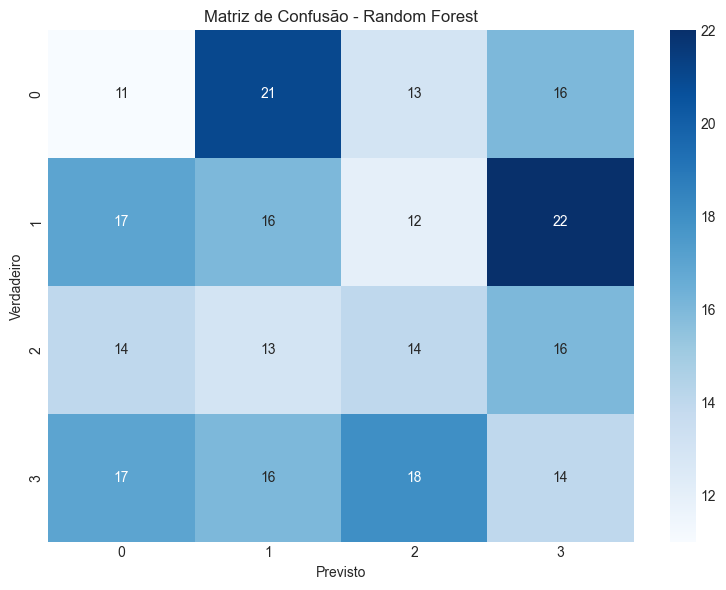


Random Forest é um classificador multiclasse (4 classes).
A plotagem da curva ROC para multiclasse pode ser feita por classe (OvR) ou com médias.


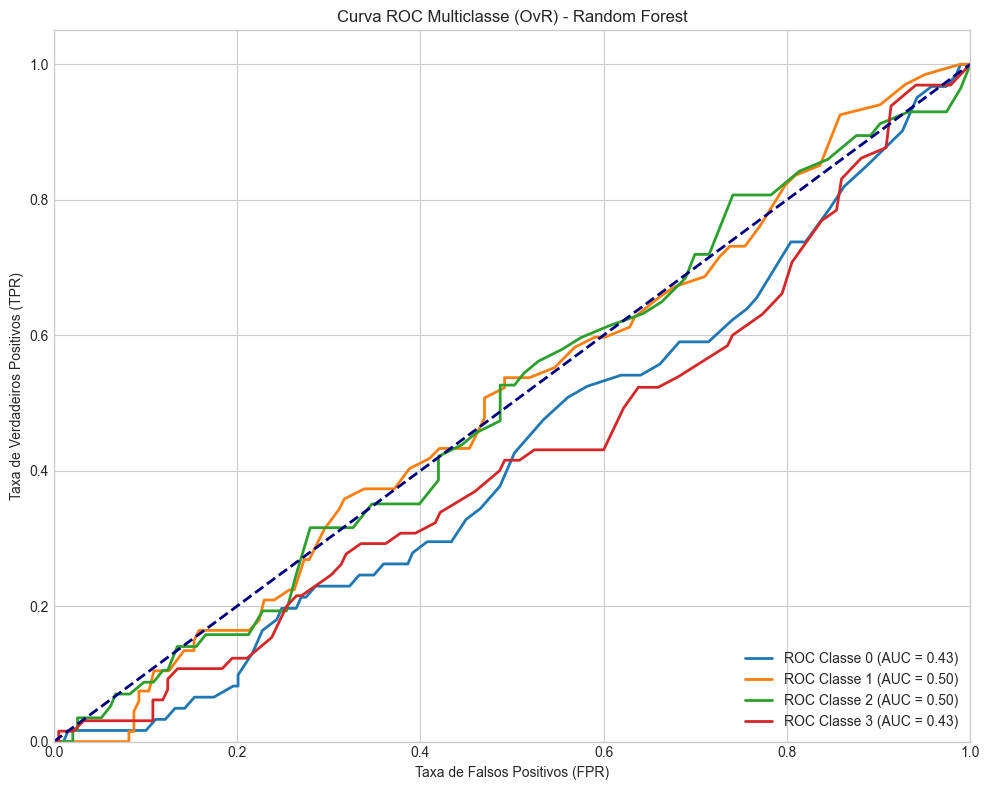

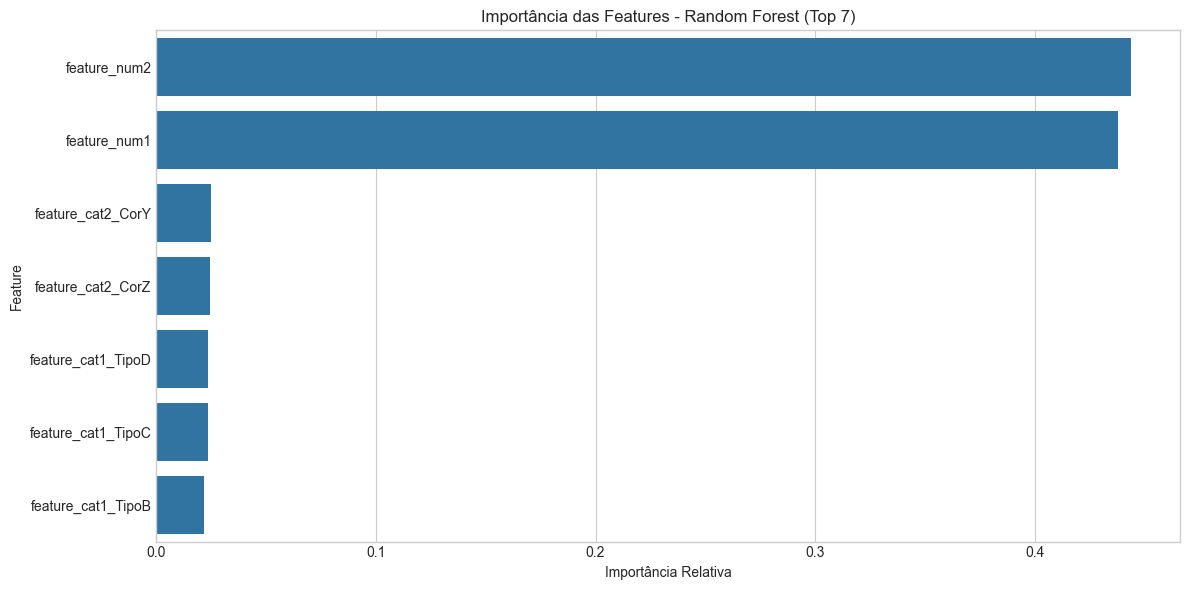

--- Avaliação de Random Forest Concluída ---
--------------------------------------------------
--- Treinando e Avaliando: XGBoost ---


c:\Users\Vinícius\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:02:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.24      0.20      0.22        61
           1       0.21      0.24      0.23        67
           2       0.20      0.19      0.19        57
           3       0.26      0.28      0.27        65

    accuracy                           0.23       250
   macro avg       0.23      0.23      0.23       250
weighted avg       0.23      0.23      0.23       250

Acurácia: 0.2280
Precisão (ponderada): 0.2283
Recall (ponderado): 0.2280
F1-Score (ponderado): 0.2274


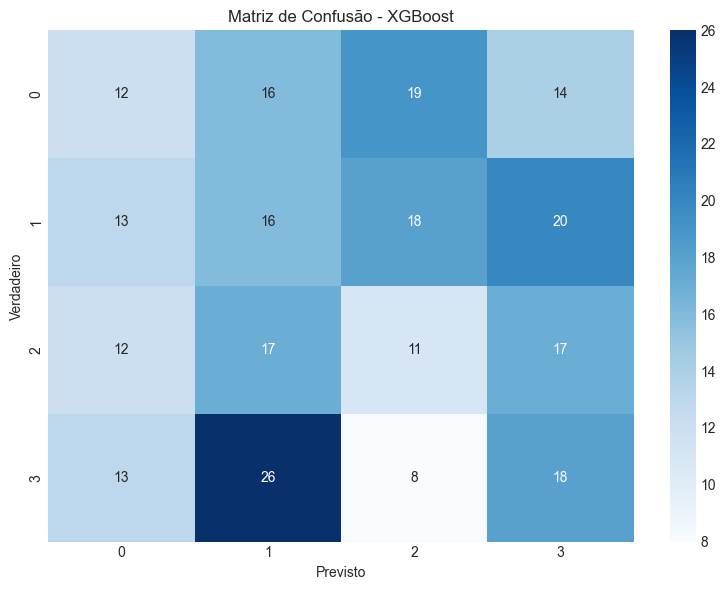


XGBoost é um classificador multiclasse (4 classes).
A plotagem da curva ROC para multiclasse pode ser feita por classe (OvR) ou com médias.


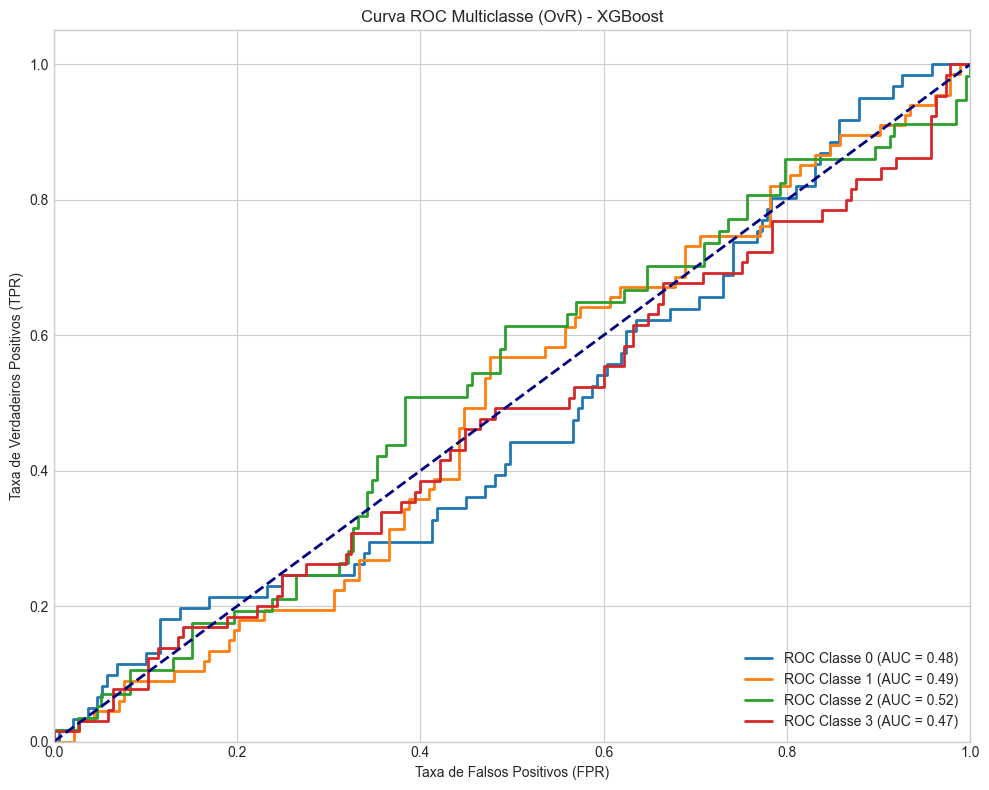

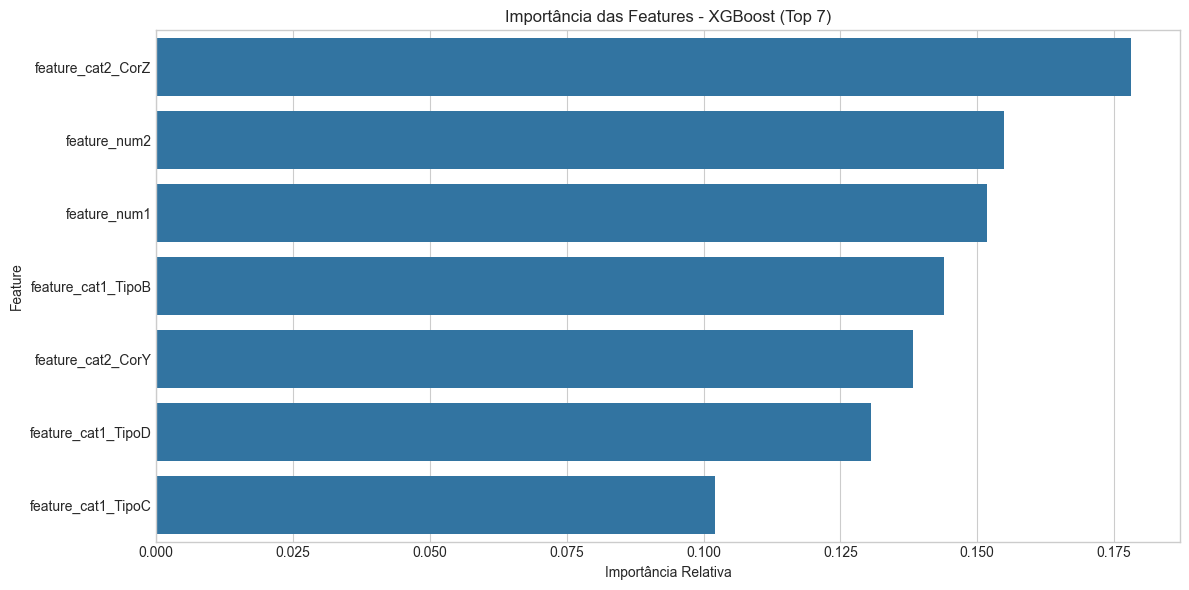

--- Avaliação de XGBoost Concluída ---
--------------------------------------------------

--- Análises Adicionais e Próximos Passos (Relembrando) ---
1. Comparação de Modelos.
2. Otimização de Hiperparâmetros (GridSearchCV, RandomizedSearchCV).
3. Validação Cruzada (Cross-Validation).
4. Análise de Erros (Matriz de Confusão).
5. Engenharia de Features.


In [215]:
# --- Exemplo de Fluxo de Uso ---

# 0. CRIAR UM DATAFRAME DE EXEMPLO (substitua pelo seu df_processado)
data_simulada = {
    'feature_num1': np.random.rand(1000),
    'feature_num2': np.random.randn(1000) * 10,
    'feature_cat1': np.random.choice(['TipoA', 'TipoB', 'TipoC', 'TipoD'], size=1000),
    'feature_cat2': np.random.choice(['CorX', 'CorY', 'CorZ'], size=1000),
    'minha_classe_alvo': np.random.choice(['Grupo Alpha', 'Grupo Beta', 'Grupo Gamma', 'Grupo Delta'], size=1000) # Alvo multiclasse
}
df_processado_exemplo = pd.DataFrame(data_simulada)
print("DataFrame de Exemplo (primeiras linhas):")
print(df_processado_exemplo.head())
print("-" * 50)

# 1. Definir a variável alvo (target) e as features (X)
nome_coluna_alvo = 'minha_classe_alvo' # Sua coluna alvo multiclasse

if nome_coluna_alvo not in df_processado_exemplo.columns:
    print(f"ERRO: Coluna alvo '{nome_coluna_alvo}' não encontrada no DataFrame!")
else:
    y_original = df_processado_exemplo[nome_coluna_alvo]
    X_original = df_processado_exemplo.drop(columns=[nome_coluna_alvo])
    
    print(f"\nVariável Alvo Selecionada: '{nome_coluna_alvo}' (Multiclasse)")
    print("-" * 50)

    # 2. Codificar Features Categóricas em X (One-Hot Encoding)
    colunas_categoricas_X = X_original.select_dtypes(include=['object', 'category']).columns
    X_codificado = pd.get_dummies(X_original, columns=colunas_categoricas_X, drop_first=True)
    feature_names = X_codificado.columns.tolist()
    print("\nFeatures (X) após One-Hot Encoding (primeiras linhas):")
    print(X_codificado.head())
    print(f"Número de features após encoding: {X_codificado.shape[1]}")
    print("-" * 50)

    # 3. Codificar Variável Alvo (y) para formato numérico 0..N-1
    le = LabelEncoder()
    y_codificada = le.fit_transform(y_original) # Converte strings/categorias para 0, 1, 2...
    
    print(f"\nCodificação da Variável Alvo '{nome_coluna_alvo}':")
    print("Classes originais:", le.classes_) # Mostra as classes originais e sua ordem de codificação
    print("Classes codificadas (únicas):", np.unique(y_codificada))
    print("Alvo (y) após codificação (primeiras ocorrências):", y_codificada[:5])
    print("-" * 50)

    # 4. Dividir em Dados de Treino e Teste
    try:
        X_train, X_test, y_train, y_test = train_test_split(
            X_codificado, y_codificada, test_size=0.25, random_state=42, stratify=y_codificada
        )
    except ValueError:
        print("Aviso: Não foi possível usar 'stratify'. Tentando sem.")
        X_train, X_test, y_train, y_test = train_test_split(
            X_codificado, y_codificada, test_size=0.25, random_state=42
        )
    print(f"\nDimensões dos conjuntos de treino/teste estabelecidas.")
    print("-" * 50)

    # 5. Treinar e Avaliar Modelos
    
    # Random Forest
    # RandomForestClassifier lida bem com y_codificada (0,1,2...) diretamente
    modelo_rf_final = treinar_random_forest(X_train, y_train, X_test, y_test, feature_names,
                                            n_estimators=120, class_weight='balanced') # Exemplo com class_weight
    print("-" * 50)
    
    # XGBoost
    # XGBoost também usará y_codificada (0,1,2...)
    modelo_xgb_final = treinar_xgboost(X_train, y_train, X_test, y_test, feature_names,
                                       n_estimators=120, learning_rate=0.1, max_depth=4)
    print("-" * 50)

    print("\n--- Análises Adicionais e Próximos Passos (Relembrando) ---")
    print("1. Comparação de Modelos.")
    print("2. Otimização de Hiperparâmetros (GridSearchCV, RandomizedSearchCV).")
    print("3. Validação Cruzada (Cross-Validation).")
    print("4. Análise de Erros (Matriz de Confusão).")
    print("5. Engenharia de Features.")